In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from zuko.flows import UnconditionalDistribution
from torch.distributions import Cauchy, Normal, Laplace, Bernoulli, Uniform
from causalflows.flows import CausalFlow
import copy
import numpy as np
from scipy.stats import betaprime, norm
from architectures import get_nsf_transforms

In [2]:
# ── Data ─────────────────────────────────────────────────────
seed = 0 # 0
torch.manual_seed(seed)
N_train = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

B = torch.cat([torch.ones(N_train // 2), torch.zeros(N_train // 2)])
Y0 = B
Y1 = 2*Y0

# ── Build base and transforms ───────────────────────────────
d = 1   # dim(Y)
# two bases (here both Gaussian; you could swap in Laplace etc.)
base0 = UnconditionalDistribution(Laplace, loc=torch.zeros(d), scale=torch.ones(d), buffer=True)
base1 = UnconditionalDistribution(Laplace, loc=torch.zeros(d), scale=torch.ones(d), buffer=True)

# transform
nsf0,nsf1 = get_nsf_transforms()

# instantiate two flows
flow0 = CausalFlow(transform=nsf0, base=base0).to(device)
flow1 = copy.deepcopy(CausalFlow(transform=nsf1, base=base1).to(device))

In [3]:
from torch.optim import Adam

# common hyper‐params
lr = 1e-3
batch_size = 128
num_epochs = 1000

# ── DataLoaders ──────────────────────────────────────────────
loader0 = DataLoader(TensorDataset(Y0), batch_size=batch_size, shuffle=True)
loader1 = DataLoader(TensorDataset(Y1), batch_size=batch_size, shuffle=True)

# ── Optimizers ───────────────────────────────────────────────
opt0 = Adam(flow0.parameters(), lr=lr)
opt1 = Adam(flow1.parameters(), lr=lr)

# ── 3) Training loops ─────────────────────────────────────────────────────────
for epoch in range(1, num_epochs+1):
    # train flow0 on Y0
    running0 = 0.0
    for (y_batch,) in loader0:
        y_batch = y_batch.to(device)
        dist0 = flow0()                           # returns a Distribution over Y
        loss0 = -dist0.log_prob(y_batch).mean()   # negative log-likelihood
        opt0.zero_grad()
        loss0.backward()
        opt0.step()
        running0 += loss0.item() * y_batch.size(0)
        
    # train flow1 on Y1
    running1 = 0.0
    for (y_batch,) in loader1:
        y_batch = y_batch.to(device)
        dist1 = flow1()
        loss1 = -dist1.log_prob(y_batch).mean()
        opt1.zero_grad()
        loss1.backward()
        opt1.step()
        running1 += loss1.item() * y_batch.size(0)

    if epoch % 50 == 0 or epoch == 1:
        print(f"Epoch {epoch:4d} | flow0 NLL = {running0/N_train:.3f} | flow1 NLL = {running1/N_train:.3f}")


Epoch    1 | flow0 NLL = 451.821 | flow1 NLL = 343.228
Epoch   50 | flow0 NLL = 134.663 | flow1 NLL = -71.440
Epoch  100 | flow0 NLL = 92.539 | flow1 NLL = -129.804
Epoch  150 | flow0 NLL = -91.021 | flow1 NLL = -178.960
Epoch  200 | flow0 NLL = -189.970 | flow1 NLL = -215.742
Epoch  250 | flow0 NLL = -263.248 | flow1 NLL = -248.120
Epoch  300 | flow0 NLL = -326.636 | flow1 NLL = -279.416
Epoch  350 | flow0 NLL = -377.193 | flow1 NLL = -308.992
Epoch  400 | flow0 NLL = -436.822 | flow1 NLL = -333.476
Epoch  450 | flow0 NLL = -467.322 | flow1 NLL = -345.165
Epoch  500 | flow0 NLL = -503.031 | flow1 NLL = -376.038
Epoch  550 | flow0 NLL = -550.974 | flow1 NLL = -377.773
Epoch  600 | flow0 NLL = -579.850 | flow1 NLL = -406.899
Epoch  650 | flow0 NLL = -590.510 | flow1 NLL = -418.338
Epoch  700 | flow0 NLL = -621.204 | flow1 NLL = -413.683
Epoch  750 | flow0 NLL = -615.618 | flow1 NLL = -437.626
Epoch  800 | flow0 NLL = -654.012 | flow1 NLL = -464.438
Epoch  850 | flow0 NLL = -587.928 | fl

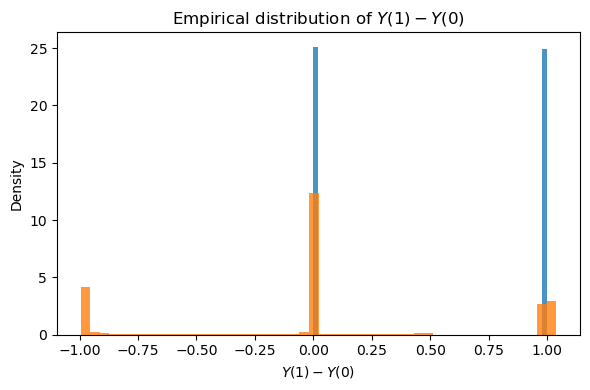

In [4]:
# ── 4) Abduct Act Predict ──────────────────────────────────────────
N_effect = 100000
dist0 = flow0()
with torch.no_grad():
    u = dist0.base.sample((N_effect,1))
    Y0_eff = dist0.transform.inv(u).cpu().squeeze()
dist1 = flow1()
with torch.no_grad():
    Y1_eff = dist1.transform.inv(u).cpu().squeeze()
delta = (Y1_eff - Y0_eff)

Y0 = Bernoulli(0.5).sample((N_effect,))
Y1 = Y0*2
true_delta = Y1-Y0

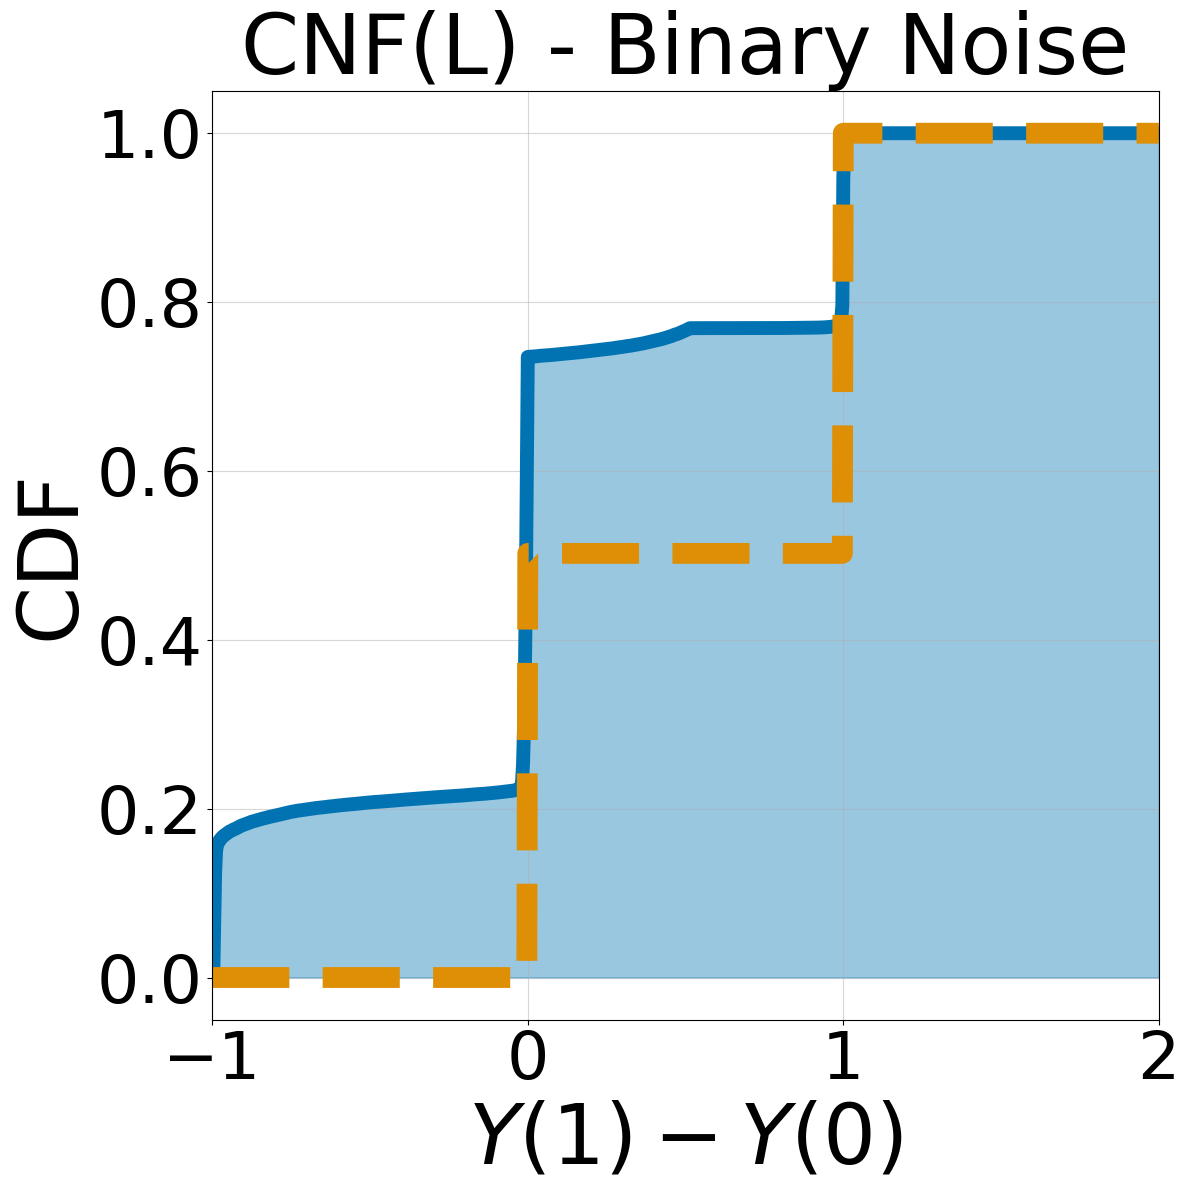

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

# Define fixed x-grid
x_grid = np.linspace(-1, 2, 1000)

# Sort inputs
delta_sorted = np.sort(delta)
true_delta_sorted = np.sort(true_delta)

# Compute empirical CDFs on fixed grid
cdf_delta = np.searchsorted(delta_sorted, x_grid, side="right") / len(delta_sorted)
cdf_true = np.searchsorted(true_delta_sorted, x_grid, side="right") / len(true_delta_sorted)

# Colors
col_data, col_true = sns.color_palette("colorblind", 2)

# Plot
plt.rcdefaults()
fig, ax = plt.subplots(figsize=(12, 12))

ax.plot(x_grid, cdf_delta, color=col_data, lw=10, label="Estimated")
ax.fill_between(x_grid, 0, cdf_delta, color=col_data, alpha=0.4)
ax.plot(x_grid, cdf_true, color=col_true, lw=15, ls="--", label="True")

ax.set_xlabel(r"$Y(1) - Y(0)$", fontsize=60)
ax.set_ylabel("CDF", fontsize=60)
ax.set_title(r"CNF(L) - Binary Noise", fontsize=60)
ax.set_xlim([-1, 2])
ax.tick_params(axis='x', labelsize=48)  # or whatever size you want
ax.tick_params(axis='y', labelsize=48)  # or whatever size you want
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
#ax.legend(frameon=False, fontsize=48)
ax.grid(alpha=0.5)
fig.tight_layout()
fig.savefig("laplace_flow_binary_ex.png", bbox_inches="tight")
plt.show()